In [637]:
import datetime
import os
from time import time

import argparse
import csv 
import keras
import numpy as np
import shutil
from sklearn.preprocessing import LabelBinarizer,LabelEncoder,OneHotEncoder
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, BatchNormalization, Convolution2D, Dense, Dropout, Flatten, MaxPooling2D, LSTM
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.regularizers import l2
from recurrentshop import *
from keras.layers import *
from keras.models import Model
from keras.applications.vgg16 import VGG16
import h5py
import midi
from fractions import Fraction
import shutil

In [2]:
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image as KImage
from keras.models import Sequential, Model
from keras.layers import Flatten
import os, sys, numpy as np
from pdf2image import convert_from_path, convert_from_bytes
from PIL import Image
import re

In [3]:
id_file = 'scripts/{}_good_ids.csv'
t_file_data = 'scripts/{}/training/{}.{}'
v_file_data = 'scripts/{}/validation/{}.{}'
e_file_data = 'scrips/{}/evaluation/{}.{}'

In [4]:
DIRS = ["training","evalation","validation"]

In [5]:
def convert_dir_pdf2img():
    for parent_dir in DIRS:
        print("Working on %s" % parent_dir)
        print("==========================")
        dir_pdf = 'scripts/%s/pdfs' % parent_dir
        dir_notes = 'scripts/%s/notes' % parent_dir
        dir_images = 'scripts/%s/images' % parent_dir
        if os.path.exists(dir_images):
            shutil.rmtree(dir_images)
        os.makedirs(dir_images)
        print("\n")
        id_list = set()
        for subdir, _, files in os.walk(dir_notes):
            for file in files:
                id_list.add((file[:-4]))
        for subdir, _, files in os.walk(dir_pdf):
            for file in files:
                if file[:-4] in id_list:
                    images = convert_from_path(os.path.join(subdir, file), \
                                              output_folder=dir_images, dpi=300, fmt='jpg')
                    temp_files = [image.filename for image in images]
                    for i,f in enumerate(temp_files):
                        if len(temp_files)==1:
                            os.rename(f,"{}/{}.jpg".format(dir_images,file[:-4]))
                        else:
                            os.rename(f,"{}/{}-{}.jpg".format(dir_images,file[:-4],i+1))

In [6]:
dir_ids = {}
for parent_dir in DIRS:
    print("Working on %s" % parent_dir)
    print("==========================")
    dir_pdf = 'scripts/%s/pdfs' % parent_dir
    dir_notes = 'scripts/%s/notes' % parent_dir
    id_list = set()
    for subdir, _, files in os.walk(dir_notes):
        for file in files:
            id_list.add((file[:-4]))
    dir_ids[parent_dir] = id_list

Working on training
Working on evalation
Working on validation


In [7]:
DIRS = ["training","evalation","validation"]

In [8]:
def load_images(image_list):
    images = []
    for i in image_list:
        c_img = np.expand_dims(KImage.img_to_array(KImage.load_img(i, target_size = (224, 224))), axis = 0)
        images.append(c_img)
    return preprocess_input(np.vstack(images))

In [9]:
def image_generator(fnames, batch_size):
    while True: #Keras generators need to loop forever for some reason...
        cfns = []
        for i, p in enumerate(fnames):
            cfns.append(p)
            if len(cfns) == batch_size:
                yield load_images(cfns)
                cfns = []
        if len(cfns) != 0:
            yield load_images(cfns)
            cfns = []

In [10]:
base_model = ResNet50()
base_model.trainable = False
image_model = Sequential()

image_model.add(Model(input = base_model.input,
                      output=base_model.get_layer('avg_pool').output))
image_model.add(Flatten())

image_model.summary()

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
regex = re.compile('([0-9]+)-([0-9]+).jpg')
def build_vector_features(base_model,output_dir,file_list):
    all_ids = []
    all_paths = []
    for subdir, _, files in os.walk(file_list):
        for i,file in enumerate(files):
            if not bool(regex.search(file)):
                all_ids.append(file[:-4])
                all_paths.append(os.path.join(subdir, file))
    fpath = "{}/vectors.out".format(output_dir)
    print("Extracting from {} files".format(len(all_paths)))
    print('Saving to {}'.format(fpath))
    gen = image_generator(all_paths, 1)
    feats = image_model.predict_generator(gen, len(all_paths),use_multiprocessing=True,verbose=1)
    np.savetxt(fpath,feats)
    return all_ids

In [156]:
def grab_ids(file_list):
    all_ids = []
    for subdir, _, files in os.walk(file_list):
        for i,file in enumerate(files):
            if not bool(regex.search(file)):
                all_ids.append(file[:-4])
    return all_ids

In [157]:
id_dir = {}
for i,parent_dir in enumerate(DIRS):
    print("Working on %s" % parent_dir)
    print("==========================")
    output_dir = 'scripts/%s' % parent_dir
    dir_imgs = '%s/images' % output_dir
    id_dir[DIRS[i]] = grab_ids(dir_imgs)

Working on training
Working on evalation
Working on validation


In [14]:
# id_dir = {}
# for i,parent_dir in enumerate(DIRS):
#     print("Working on %s" % parent_dir)
#     print("==========================")
#     output_dir = 'scripts/%s' % parent_dir
#     dir_imgs = '%s/images' % output_dir
#     id_dir[DIRS[i]] = build_vector_features(base_model,output_dir,dir_imgs)

In [243]:
training_data = np.loadtxt("scripts/training/vectors.out")
evaluation_data = np.loadtxt("scripts/evalation/vectors.out")
validation_data = np.loadtxt("scripts/validation/vectors.out")

In [252]:
a = np.arange(20).reshape((5,4))
a[np.ix_([0,1,4],)]

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [16, 17, 18, 19]])

In [16]:
def note_check(note):
    pitch,octave = note.split("_")
    if pitch == "Cb":
        pitch = "B"
    elif pitch == "Bs":
        pitch = "C"
    elif pitch == "Es":
        pitch = "F"
    elif pitch == "Fb":
        pitch = "E"
    return "{}_{}".format(pitch.replace("sb","").replace("bs",""),octave)
def parser(note):
    indx = re.search(r"[0-9]", note).start()
    return note_check(note[:indx].replace("#","s").replace("-","b") + "_" + note[indx:])
def parse_val(v):
    try:
        new_v = float(v)
    except ValueError:
        new_v = float(Fraction(v))
    return new_v

In [185]:
flatten = lambda l: [item for sublist in l for item in sublist]
import csv
def build_data(data_type):
    training_data = []
    good_ids = []
    for file_name in id_dir[data_type]:
        with open('scripts/{}/pitchNotes/{}.csv'.format(data_type,file_name),'r') as f:
            intermediate = [[float(tuple(line)[0]),parse_val((tuple(line)[1]))] for line in csv.reader(f)]
            if len(intermediate) > 0:
                training_data.append(intermediate)
                good_ids.append(file_name)
    return (training_data,np.array(flatten(training_data)),good_ids)

In [186]:
training_results,flattened_training_results,training_good_ids = build_data("training")

In [187]:
validation_results,flattened_validation_results,validation_good_ids = build_data("validation")

In [188]:
evaluation_results,flattened_evaluation_results,evaluation_good_ids = build_data("evalation")

In [191]:
flattened_training_results[:,0]

array([67., 68., 67., ..., 65., 64., 62.])

In [192]:
flattened_training_results[:,0][0:5]

array([67., 68., 67., 66., 67.])

In [193]:
flattened_training_results[0:5]

array([[67.,  4.],
       [68.,  1.],
       [67.,  1.],
       [66.,  1.],
       [67.,  1.]])

In [194]:
lb_pitch = LabelBinarizer()
lb_pitch.fit(np.concatenate((np.concatenate((flattened_training_results[:,0],\
                            flattened_validation_results[:,0])),
                            flattened_evaluation_results[:,0])))
le_duration = LabelEncoder()
le_duration.fit(np.concatenate((np.concatenate((flattened_training_results[:,1],\
                            flattened_validation_results[:,1])),
                            flattened_evaluation_results[:,1])))
lb_duration = LabelBinarizer()
lb_duration.fit([le_duration.transform([r])[0] for r in \
                 np.concatenate((np.concatenate((flattened_training_results[:,1],
                                               flattened_validation_results[:,1])),
                                flattened_evaluation_results[:,1]))])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [197]:
def encode_pitch_duration(pd):
    return np.concatenate((lb_pitch.transform([pd[0]])[0]\
                           ,lb_duration.transform(le_duration.transform([pd[1]]))[0]))
def decode_pitch_duration(one_hot):
    INDX = 122
    return [lb_pitch.inverse_transform(np.array([one_hot[:INDX]])),\
            le_duration.inverse_transform(lb_duration.inverse_transform(np.array([one_hot[INDX:]])))]

In [987]:
decode_pitch_duration(encode_pitch_duration([44.,0.5]))

(665,)

In [369]:
stop_state = np.zeros((1,666))
stop_state[0][665] = 1.

In [370]:
one_hot_training_data = []
for s in training_results:
    one_hot_training_data.append(np.array([np.append(encode_pitch_duration(tup),0) for tup in s]))
one_hot_training_data = np.array(one_hot_training_data)

In [371]:
one_hot_validation_data = []
for s in validation_results:
    one_hot_validation_data.append(np.array([np.append(encode_pitch_duration(tup),0) for tup in s]))
one_hot_validation_data = np.array(one_hot_validation_data)

In [372]:
one_hot_evaluation_data = []
for s in evaluation_results:
    one_hot_evaluation_data.append(np.array([np.append(encode_pitch_duration(tup),0) for tup in s]))
one_hot_evaluation_data = np.array(one_hot_evaluation_data)

In [373]:
def shorten(input_mat):
    return np.array([row[:400] for row in input_mat])

In [374]:
training_output_data = shorten(one_hot_training_data)
validation_output_data = shorten(one_hot_validation_data)
evaluation_output_data = shorten(one_hot_validation_data)

In [375]:
%matplotlib inline
import matplotlib.pyplot as plt 

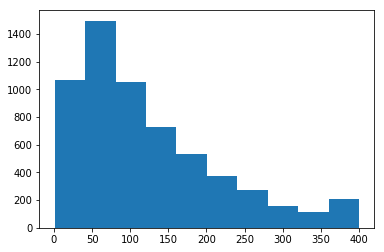

In [376]:
plt.hist([ a.shape[0] for a in training_output_data])
plt.show()

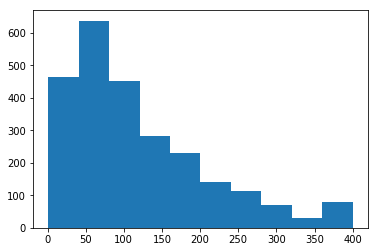

In [377]:
plt.hist([ a.shape[0] for a in validation_output_data])
plt.show()

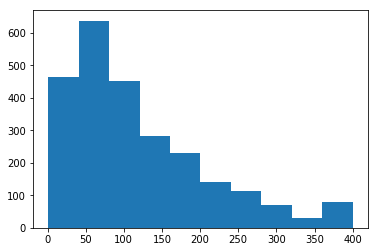

In [378]:
plt.hist([ a.shape[0] for a in evaluation_output_data])
plt.show()

In [379]:
def build_encoder_decoder(
    NUM_IMAGE_VEC_DIM = 2048,
    N = 1,
    L = 400,
    LSTM_INPUT_SIZE = 256,
    DECODER_SIZE = 666,
    DECODER_OUTPUT = 666):   
    # Input is a 2 dimensional array of size (n,2048).
    encoder_inputs = Input(shape=(N,NUM_IMAGE_VEC_DIM))
    # Input into Dense(256) layer which will turn (n,2048) into (n,256)
    image_dense = TimeDistributed(Dense(LSTM_INPUT_SIZE))
    image_dense_input = image_dense(encoder_inputs)
    encoder = LSTM(LSTM_INPUT_SIZE, return_state=True)
    encoder_outputs, state_h, state_c = encoder(image_dense_input)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]
    decoder_inputs = Input(shape=(L,DECODER_SIZE))
    inv_image_dense = TimeDistributed(Dense(LSTM_INPUT_SIZE))
    decoder_lstm = LSTM(LSTM_INPUT_SIZE, return_sequences=True, return_state=True)
    # Set up the decoder, using `encoder_states` as initial state.
    decoder_outputs, _, _ = decoder_lstm(inv_image_dense(decoder_inputs),
                                         initial_state=encoder_states)
    # Softmax because it is multi-class classification
    decoder_dense = Dense(DECODER_OUTPUT, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    return Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [380]:
ec_model = build_encoder_decoder()

In [381]:
ec_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 1, 2048)      0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 400, 666)     0                                            
__________________________________________________________________________________________________
time_distributed_26 (TimeDistri (None, 1, 256)       524544      input_27[0][0]                   
__________________________________________________________________________________________________
time_distributed_27 (TimeDistri (None, 400, 256)     170752      input_28[0][0]                   
__________________________________________________________________________________________________
lstm_26 (L

In [382]:
ec_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [383]:
middle_c = np.append(encode_pitch_duration([48.,1.0]),0)

In [387]:
inv_id_training = {k:i for i,k in enumerate(id_dir["training"])}
inv_id_validation = {k:i for i,k in enumerate(id_dir["validation"])}
inv_id_evaluation = {k:i for i,k in enumerate(id_dir["evalation"])}

In [388]:
new_training_data_vectors = training_data[np.ix_([inv_id_training[k] for k in training_good_ids],)]
new_validation_data_vectors = validation_data[np.ix_([inv_id_validation[k] for k in validation_good_ids],)]
new_evaluation_data_vectors = evaluation_data[np.ix_([inv_id_evaluation[k] for k in evaluation_good_ids],)]

In [389]:
encoder_input_data_training = np.array([k.reshape(1,2048) for k in new_training_data_vectors])
encoder_input_data_validation = np.array([k.reshape(1,2048) for k in new_validation_data_vectors])
encoder_input_data_evaluation = np.array([k.reshape(1,2048) for k in new_evaluation_data_vectors])

In [471]:
encoder_input_data_evaluation.shape

(1513, 1, 2048)

In [442]:
def padding(input_mat,N=400):
    (num_rows,vec_size) = input_mat.shape
    num_to_pad = N-num_rows
    if (num_to_pad == 0):
        return input_mat
    elif (num_to_pad > 0):
        return np.vstack((input_mat,np.zeros((num_to_pad,vec_size))))
    else:
        return input_mat[:N]

In [443]:
decoder_input_data_training = np.array([padding(np.vstack((k[1:],stop_state))) for k in one_hot_training_data])
decoder_output_data_training = np.array([padding(np.vstack((middle_c,k[:-1]))) for k in one_hot_training_data])

In [473]:
decoder_input_data_validation = np.array([padding(np.vstack((k[1:],stop_state))) for k in one_hot_validation_data])
decoder_output_data_validation = np.array([padding(np.vstack((middle_c,k[:-1]))) for k in one_hot_validation_data])

In [481]:
decoder_input_data_evaluation = np.array([padding(np.vstack((k[1:],stop_state))) for k in one_hot_evaluation_data])
decoder_output_data_evaluation = np.array([padding(np.vstack((middle_c,k[:-1]))) for k in one_hot_evaluation_data])

In [447]:
print(training_data_vectors.shape)
print(decoder_input_data_training.shape)
print(decoder_output_data_training.shape)

(6012, 1, 2048)
(6012, 400, 666)
(6012, 400, 666)


In [477]:
ec_model_2 = build_encoder_decoder()

In [479]:
ec_model_2.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [480]:
ec_model_2.fit([encoder_input_data_training,decoder_input_data_training], decoder_output_data_training,
          batch_size=256,
          epochs=50,
          validation_data=([encoder_input_data_validation,decoder_input_data_validation],\
                          decoder_output_data_validation))

Train on 6012 samples, validate on 2497 samples
Epoch 1/50
6012/6012 [==============================] - 485s 81ms/step - loss: 2.3322 - val_loss: 2.0088
Epoch 2/50
6012/6012 [==============================] - 483s 80ms/step - loss: 2.0052 - val_loss: 1.8849
Epoch 3/50
6012/6012 [==============================] - 482s 80ms/step - loss: 1.8840 - val_loss: 1.7842
Epoch 4/50
6012/6012 [==============================] - 485s 81ms/step - loss: 1.7305 - val_loss: 1.6458
Epoch 5/50
6012/6012 [==============================] - 486s 81ms/step - loss: 1.5792 - val_loss: 1.4887
Epoch 6/50
6012/6012 [==============================] - 485s 81ms/step - loss: 1.4678 - val_loss: 1.3724
Epoch 7/50
6012/6012 [==============================] - 482s 80ms/step - loss: 1.3691 - val_loss: 1.3160
Epoch 8/50
6012/6012 [==============================] - 484s 80ms/step - loss: 1.2849 - val_loss: 1.2360
Epoch 9/50
6012/6012 [==============================] - 489s 81ms/step - loss: 1.2140 - val_loss: 1.1534
Epoch 1

In [485]:
ec_model_2.evaluate([encoder_input_data_evaluation,decoder_input_data_evaluation],\
                    decoder_output_data_evaluation,\
                    batch_size=256,\
                    verbose=1)

1513/1513 [==============================] - 29s 19ms/step


0.4519499409340583

In [491]:
ec_model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 1, 2048)      0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 400, 666)     0                                            
__________________________________________________________________________________________________
time_distributed_28 (TimeDistri (None, 1, 256)       524544      input_29[0][0]                   
__________________________________________________________________________________________________
time_distributed_29 (TimeDistri (None, 400, 256)     170752      input_30[0][0]                   
__________________________________________________________________________________________________
lstm_28 (L

In [474]:
ec_model.fit([encoder_input_data_training,decoder_input_data_training], decoder_output_data_training,
          batch_size=256,
          epochs=25,
          validation_data=([encoder_input_data_validation,decoder_input_data_validation],\
                          decoder_output_data_validation))

Train on 6012 samples, validate on 2497 samples
Epoch 1/25
6012/6012 [==============================] - 572s 95ms/step - loss: 1.1809 - val_loss: 1.1062
Epoch 2/25
6012/6012 [==============================] - 546s 91ms/step - loss: 1.1138 - val_loss: 1.0417
Epoch 3/25
6012/6012 [==============================] - 538s 90ms/step - loss: 1.0494 - val_loss: 0.9829
Epoch 4/25
6012/6012 [==============================] - 529s 88ms/step - loss: 0.9769 - val_loss: 0.9203
Epoch 5/25
6012/6012 [==============================] - 541s 90ms/step - loss: 0.9054 - val_loss: 0.8456
Epoch 6/25
6012/6012 [==============================] - 545s 91ms/step - loss: 0.8387 - val_loss: 0.7862
Epoch 7/25
6012/6012 [==============================] - 544s 90ms/step - loss: 0.7782 - val_loss: 0.7348
Epoch 8/25
6012/6012 [==============================] - 1153s 192ms/step - loss: 0.7240 - val_loss: 0.6775
Epoch 9/25
6012/6012 [==============================] - 472s 79ms/step - loss: 0.6707 - val_loss: 0.6244
Epoch

In [476]:
ec_model.save('initial_model_25.h5')

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_27 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_26/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_26/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [486]:
ec_model_2.save('initial_model_50.h5')

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_29 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_28/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_28/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [498]:
ec_model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 1, 2048)      0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 400, 666)     0                                            
__________________________________________________________________________________________________
time_distributed_28 (TimeDistri (None, 1, 256)       524544      input_29[0][0]                   
__________________________________________________________________________________________________
time_distributed_29 (TimeDistri (None, 400, 256)     170752      input_30[0][0]                   
__________________________________________________________________________________________________
lstm_28 (L

In [638]:
ec_model = load_model('initial_model_25.h5')
ec_model_2 = load_model('initial_model_50.h5')

In [640]:
ec_model_2.evaluate([encoder_input_data_evaluation,decoder_input_data_evaluation],\
                    decoder_output_data_evaluation,\
                    batch_size=256,\
                    verbose=1)

1513/1513 [==============================] - 39s 26ms/step


0.4519499409340583

In [641]:
ec_model.evaluate([encoder_input_data_evaluation,decoder_input_data_evaluation],\
                    decoder_output_data_evaluation,\
                    batch_size=256,\
                    verbose=1)

1513/1513 [==============================] - 35s 23ms/step


0.4791718912258577

# BEGIN LOOKING HERE

In [1064]:
NUM_IMAGE_VEC_DIM = 2048
N = 1
L = 400
LSTM_INPUT_SIZE = 256
DECODER_SIZE = 666
DECODER_OUTPUT = 666
# Input is a 2 dimensional array of size (n,2048).
encoder_inputs = Input(shape=(N,NUM_IMAGE_VEC_DIM))
# Input into Dense(256) layer which will turn (n,2048) into (n,256)
image_dense = TimeDistributed(Dense(LSTM_INPUT_SIZE))
image_dense_input = image_dense(encoder_inputs)
encoder = LSTM(LSTM_INPUT_SIZE, return_state=True)
encoder_outputs, state_h, state_c = encoder(image_dense_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
inv_image_dense = TimeDistributed(Dense(LSTM_INPUT_SIZE))
decoder_lstm = LSTM(LSTM_INPUT_SIZE, return_sequences=True, return_state=True)
decoder_inputs = Input(shape=(L,DECODER_SIZE))
# Set up the decoder, using `encoder_states` as initial state.
decoder_outputs, _, _ = decoder_lstm(inv_image_dense(decoder_inputs),
                                     initial_state=encoder_states)
# Softmax because it is multi-class classification
decoder_dense = Dense(DECODER_OUTPUT, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
intro_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
intro_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [1065]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(intro_model).create(prog='dot', format='svg'))

In [1066]:
intro_model.fit([encoder_input_data_training,decoder_input_data_training], decoder_output_data_training,
          batch_size=334,
          epochs=25,
          validation_data=([encoder_input_data_validation,decoder_input_data_validation],\
                          decoder_output_data_validation))

Train on 6012 samples, validate on 2497 samples
Epoch 1/25
6012/6012 [==============================] - 545s 91ms/step - loss: 2.4181 - val_loss: 2.0278
Epoch 2/25
6012/6012 [==============================] - 550s 92ms/step - loss: 2.0546 - val_loss: 1.9349
Epoch 3/25
6012/6012 [==============================] - 523s 87ms/step - loss: 1.9542 - val_loss: 1.8875
Epoch 4/25
6012/6012 [==============================] - 2312s 385ms/step - loss: 1.8840 - val_loss: 1.7799
Epoch 5/25
6012/6012 [==============================] - 526s 87ms/step - loss: 1.7738 - val_loss: 1.6401
Epoch 6/25
6012/6012 [==============================] - 524s 87ms/step - loss: 1.6539 - val_loss: 1.5441
Epoch 7/25
6012/6012 [==============================] - 544s 90ms/step - loss: 1.5515 - val_loss: 1.4773
Epoch 8/25
6012/6012 [==============================] - 561s 93ms/step - loss: 1.4629 - val_loss: 1.3857
Epoch 9/25
6012/6012 [==============================] - 587s 98ms/step - loss: 1.3879 - val_loss: 1.3073
Epoch

In [1067]:
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(1,LSTM_INPUT_SIZE))
decoder_state_input_c = Input(shape=(1,LSTM_INPUT_SIZE))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h_new, state_c_new = decoder_lstm(
    inv_image_dense(decoder_inputs), initial_state=decoder_states_inputs)
decoder_states = [state_h_new, state_c_new]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [1068]:
# intro_model.summary()

In [1069]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

In [1070]:
decoder_states_inputs

[<tf.Tensor 'input_104:0' shape=(?, 1, 256) dtype=float32>,
 <tf.Tensor 'input_105:0' shape=(?, 1, 256) dtype=float32>]

In [1071]:
decoder_states

[<tf.Tensor 'lstm_53_1/while/Exit_2:0' shape=(?, 1, 256) dtype=float32>,
 <tf.Tensor 'lstm_53_1/while/Exit_3:0' shape=(?, 1, 256) dtype=float32>]

In [1084]:
decode_middle_c = middle_c.reshape(1,1,666)
def decode_sequence(input_img):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_img)
    # Generate empty target sequence of length 400.
    target_seq = np.tile(decode_middle_c,(400,1))
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_list = []
    indx = 0
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [states_value[0].reshape(1,1,256),states_value[1].reshape(1,1,256)])
        max_indx = np.argmax(output_tokens[0][0])
        curr_result = np.zeros((1,666))
        curr_result[0][max_indx] = 1.0
        # Exit condition: either hit max length
        # or find stop character.
        if ((curr_result==stop_state).all() or\
            len(decoded_list) >= 399):
            stop_condition = True
        tup_pair = decode_pitch_duration(curr_result[0][:-1])
        decoded_list.append(tup_pair)
        indx+=1
        # Update the target sequence (of length 1).
        target_seq = output_tokens
        # Update states
        states_value = [h, c]
    return decoded_list

In [1085]:
evaluation_good_ids[3]

'45308'

In [1086]:
result = decode_sequence(evaluation_data[3].reshape(1,1,2048))

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ilanfilonenko/6700/mono-MusicXML-dataset/venv/li

In [1081]:
from music21.midi import translate
from music21 import pitch,note
from music21.articulations import Fingering,Articulation
from music21.stream import Stream

In [1082]:
def output_pdf(file_name, note_pd_lst):
    s = Stream()
    for note_pair in note_pd_lst:
        n = note.Note(pitch.Pitch(note_pair[0][0]),quarterLength=note_pair[1][0])
#         n.articulations.append((Fingering(f)))
#         print(n.articulations)
        s.append(n)
    location = str(s.write("lily.pdf"))
    os.rename(location,'{}.pdf'.format(file_name))
    mf = translate.music21ObjectToMidiFile(s)
    mf.open('{}.mid'.format(file_name), 'wb')
    mf.write()
    mf.close()

In [1087]:
output_pdf("example",result)